# Gaussian Mixture Regression

* Paper: http://www.stat.rice.edu/~hgsung/thesis.pdf
* Code: https://github.com/AlexanderFabisch/gmr/blob/master/gmr/gmm.py

# Datasets

In [10]:
from mpl_toolkits import mplot3d
def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()

def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
    """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
    x0 = np.concatenate([
        np.random.normal(10, 2, size=n),
        np.random.normal(10, 2, size=n),
        np.random.normal(20, 2, size=n),
        np.random.normal(20, 2, size=n),
    ])
    x1 = np.concatenate([
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
    ])
    y = np.concatenate([
        np.random.normal(50, 2, size=n),
        np.random.normal(60, 2, size=n),
        np.random.normal(70, 2, size=n),
        np.random.normal(80, 2, size=n),
    ])
    data = np.stack((x0, x1, y), axis=1).astype(np.float32)
    np.random.shuffle(data)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
        plt.show()
    
    return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
            if xy_features == (2,1) else \
            (np.expand_dims(data[:,0], axis=1), data[:,1:])

In [11]:
X, y = get_normal_data()
X.shape, y.shape

((4000, 2), (4000, 1))

# Scipy Implementation

In [6]:
import numpy as np
from scipy import linalg
import numbers


# Taken from scikit learn to get rid of the dependency

def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance
    If seed is None, return the RandomState singleton used by np.random.
    If seed is an int, return a new RandomState instance seeded with seed.
    If seed is already a RandomState instance, return it.
    Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)


def pinvh(a, cond=None, rcond=None, lower=True):
    """Compute the (Moore-Penrose) pseudo-inverse of a hermetian matrix.
    Calculate a generalized inverse of a symmetric matrix using its
    eigenvalue decomposition and including all 'large' eigenvalues.
    Parameters
    ----------
    a : array, shape (N, N)
        Real symmetric or complex hermetian matrix to be pseudo-inverted
    cond, rcond : float or None
        Cutoff for 'small' eigenvalues.
        Singular values smaller than rcond * largest_eigenvalue are considered
        zero.
        If None or -1, suitable machine precision is used.
    lower : boolean
        Whether the pertinent array data is taken from the lower or upper
        triangle of a. (Default: lower)
    Returns
    -------
    B : array, shape (N, N)
    Raises
    ------
    LinAlgError
        If eigenvalue does not converge
    Examples
    --------
    >>> import numpy as np
    >>> a = np.random.randn(9, 6)
    >>> a = np.dot(a, a.T)
    >>> B = pinvh(a)
    >>> np.allclose(a, np.dot(a, np.dot(B, a)))
    True
    >>> np.allclose(B, np.dot(B, np.dot(a, B)))
    True
    """
    a = np.asarray_chkfinite(a)
    s, u = linalg.eigh(a, lower=lower)

    if rcond is not None:
        cond = rcond
    if cond in [None, -1]:
        t = u.dtype.char.lower()
        factor = {'f': 1E3, 'd': 1E6}
        cond = factor[t] * np.finfo(t).eps

    # unlike svd case, eigh can lead to negative eigenvalues
    above_cutoff = (abs(s) > cond * np.max(abs(s)))
    psigma_diag = np.zeros_like(s)
    psigma_diag[above_cutoff] = 1.0 / s[above_cutoff]

    return np.dot(u * psigma_diag, np.conjugate(u).T)

In [7]:
import numpy as np
import scipy as sp


def invert_indices(n_features, indices):
    inv = np.ones(n_features, dtype=np.bool)
    inv[indices] = False
    inv, = np.where(inv)
    return inv


class MVN(object):
    """Multivariate normal distribution.
    Some utility functions for MVNs. See
    http://en.wikipedia.org/wiki/Multivariate_normal_distribution
    for more details.
    Parameters
    ----------
    mean : array, shape (n_features), optional
        Mean of the MVN.
    covariance : array, shape (n_features, n_features), optional
        Covariance of the MVN.
    verbose : int, optional (default: 0)
        Verbosity level.
    random_state : int or RandomState, optional (default: global random state)
        If an integer is given, it fixes the seed. Defaults to the global numpy
        random number generator.
    """
    def __init__(self, mean=None, covariance=None, verbose=0,
                 random_state=None):
        self.mean = mean
        self.covariance = covariance
        self.verbose = verbose
        self.random_state = check_random_state(random_state)
        self.norm = None

    def _check_initialized(self):
        if self.mean is None:
            raise ValueError("Mean has not been initialized")
        if self.covariance is None:
            raise ValueError("Covariance has not been initialized")

    def from_samples(self, X, bessels_correction=True):
        """MLE of the mean and covariance.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Samples from the true function.
        Returns
        -------
        self : MVN
            This object.
        """
        self.mean = np.mean(X, axis=0)
        bias = 0 if bessels_correction else 1
        self.covariance = np.cov(X, rowvar=0, bias=bias)
        self.norm = None
        return self

    def sample(self, n_samples):
        """Sample from multivariate normal distribution.
        Parameters
        ----------
        n_samples : int
            Number of samples.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Samples from the MVN.
        """
        self._check_initialized()
        return self.random_state.multivariate_normal(
            self.mean, self.covariance, size=(n_samples,))

    def to_probability_density(self, X):
        """Compute probability density.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Data.
        Returns
        -------
        p : array, shape (n_samples,)
            Probability densities of data.
        """
        self._check_initialized()

        X = np.atleast_2d(X)
        n_features = X.shape[1]

        C = self.covariance
        try:
            L = sp.linalg.cholesky(C, lower=True)
        except np.linalg.LinAlgError:
            C = self.covariance + 1e-6 * np.eye(n_features)
            L = sp.linalg.cholesky(C, lower=True)
        D = X - self.mean
        cov_sol = sp.linalg.solve_triangular(L, D.T, lower=True).T
        if self.norm is None:
            self.norm = 0.5 / np.pi ** (0.5 * n_features) / sp.linalg.det(L)

        DpD = np.sum(cov_sol ** 2, axis=1)
        return self.norm * np.exp(-0.5 * DpD)

    def marginalize(self, indices):
        """Marginalize over everything except the given indices.
        Parameters
        ----------
        indices : array, shape (n_new_features,)
            Indices of dimensions that we want to keep.
        Returns
        -------
        marginal : MVN
            Marginal MVN distribution.
        """
        self._check_initialized()
        return MVN(mean=self.mean[indices],
                   covariance=self.covariance[np.ix_(indices, indices)])

    def condition(self, indices, x):
        """Conditional distribution over given indices.
        Parameters
        ----------
        indices : array, shape (n_new_features,)
            Indices of dimensions that we want to condition.
        x : array, shape (n_new_features,)
            Values of the features that we know.
        Returns
        -------
        conditional : MVN
            Conditional MVN distribution p(Y | X=x).
        """
        self._check_initialized()
        mean, covariance = self._condition(
            invert_indices(self.mean.shape[0], indices), indices, x)
        return MVN(mean=mean, covariance=covariance,
                   random_state=self.random_state)

    def predict(self, indices, X):
        """Predict means and covariance of posteriors.
        Same as condition() but for multiple samples.
        Parameters
        ----------
        indices : array, shape (n_features_1,)
            Indices of dimensions that we want to condition.
        X : array, shape (n_samples, n_features_1)
            Values of the features that we know.
        Returns
        -------
        Y : array, shape (n_samples, n_features_2)
            Predicted means of missing values.
        covariance : array, shape (n_features_2, n_features_2)
            Covariance of the predicted features.
        """
        self._check_initialized()
        return self._condition(invert_indices(self.mean.shape[0], indices),
                               indices, X)

    def _condition(self, i1, i2, X):
        cov_12 = self.covariance[np.ix_(i1, i2)]
        cov_11 = self.covariance[np.ix_(i1, i1)]
        cov_22 = self.covariance[np.ix_(i2, i2)]
        prec_22 = pinvh(cov_22)
        regression_coeffs = cov_12.dot(prec_22)

        mean = self.mean[i1] + regression_coeffs.dot((X - self.mean[i2]).T).T
        covariance = cov_11 - regression_coeffs.dot(cov_12.T)
        return mean, covariance

    def to_ellipse(self, factor=1.0):
        """Compute error ellipse.
        An error ellipse shows equiprobable points.
        Parameters
        ----------
        factor : float
            One means standard deviation.
        Returns
        -------
        angle : float
            Rotation angle of the ellipse.
        width : float
            Width of the ellipse.
        height : float
            Height of the ellipse.
        """
        self._check_initialized()
        vals, vecs = sp.linalg.eigh(self.covariance)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.arctan2(*vecs[:, 0][::-1])
        width, height = factor * np.sqrt(vals)
        return angle, width, height


def plot_error_ellipse(ax, mvn):
    """Plot error ellipse of MVN.
    Parameters
    ----------
    ax : axis
        Matplotlib axis.
    mvn : MVN
        Multivariate normal distribution.
    """
    from matplotlib.patches import Ellipse
    for factor in np.linspace(0.5, 4.0, 8):
        angle, width, height = mvn.to_ellipse(factor)
        ell = Ellipse(xy=mvn.mean, width=width, height=height,
                      angle=np.degrees(angle))
        ell.set_alpha(0.25)
        ax.add_artist(ell)

In [8]:
import numpy as np


class GMM(object):
    """Gaussian Mixture Model.
    Parameters
    ----------
    n_components : int
        Number of MVNs that compose the GMM.
    priors : array, shape (n_components,), optional
        Weights of the components.
    means : array, shape (n_components, n_features), optional
        Means of the components.
    covariances : array, shape (n_components, n_features, n_features), optional
        Covariances of the components.
    verbose : int, optional (default: 0)
        Verbosity level.
    random_state : int or RandomState, optional (default: global random state)
        If an integer is given, it fixes the seed. Defaults to the global numpy
        random number generator.
    """
    def __init__(self, n_components, priors=None, means=None, covariances=None,
                 verbose=0, random_state=None):
        self.n_components = n_components
        self.priors = priors
        self.means = means
        self.covariances = covariances
        self.verbose = verbose
        self.random_state = check_random_state(random_state)

    def _check_initialized(self):
        if self.priors is None:
            raise ValueError("Priors have not been initialized")
        if self.means is None:
            raise ValueError("Means have not been initialized")
        if self.covariances is None:
            raise ValueError("Covariances have not been initialized")

    def from_samples(self, X, R_diff=1e-4, n_iter=100):
        """MLE of the mean and covariance.
        Expectation-maximization is used to infer the model parameters. The
        objective function is non-convex. Hence, multiple runs can have
        different results.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Samples from the true function.
        R_diff : float
            Minimum allowed difference of responsibilities between successive
            EM iterations.
        n_iter : int
            Maximum number of iterations.
        Returns
        -------
        self : MVN
            This object.
        """
        n_samples, n_features = X.shape

        if self.priors is None:
            self.priors = np.ones(self.n_components,
                                  dtype=np.float) / self.n_components

        if self.means is None:
            # TODO k-means++
            indices = self.random_state.choice(
                np.arange(n_samples), self.n_components)
            self.means = X[indices]

        if self.covariances is None:
            self.covariances = np.empty((self.n_components, n_features,
                                         n_features))
            for k in range(self.n_components):
                self.covariances[k] = np.eye(n_features)

        R = np.zeros((n_samples, self.n_components))
        for _ in range(n_iter):
            R_prev = R

            # Expectation
            R = self.to_responsibilities(X)

            if np.linalg.norm(R - R_prev) < R_diff:
                if self.verbose:
                    print("EM converged.")
                break

            # Maximization
            w = R.sum(axis=0) + 10.0 * np.finfo(R.dtype).eps
            R_n = R / w
            self.priors = w / w.sum()
            self.means = R_n.T.dot(X)
            for k in range(self.n_components):
                Xm = X - self.means[k]
                self.covariances[k] = (R_n[:, k, np.newaxis] * Xm).T.dot(Xm)

        return self

    def sample(self, n_samples):
        """Sample from Gaussian mixture distribution.
        Parameters
        ----------
        n_samples : int
            Number of samples.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Samples from the GMM.
        """
        self._check_initialized()

        mvn_indices = self.random_state.choice(
            self.n_components, size=(n_samples,), p=self.priors)
        mvn_indices.sort()
        split_indices = np.hstack(
            ((0,), np.nonzero(np.diff(mvn_indices))[0] + 1, (n_samples,)))
        clusters = np.unique(mvn_indices)
        lens = np.diff(split_indices)
        samples = np.empty((n_samples, self.means.shape[1]))
        for i, (k, n_samples) in enumerate(zip(clusters, lens)):
            samples[split_indices[i]:split_indices[i + 1]] = MVN(
                mean=self.means[k], covariance=self.covariances[k],
                random_state=self.random_state).sample(n_samples=n_samples)
        return samples

    def to_responsibilities(self, X):
        """Compute responsibilities of each MVN for each sample.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Data.
        Returns
        -------
        R : array, shape (n_samples, n_components)
        """
        self._check_initialized()

        n_samples = X.shape[0]
        R = np.empty((n_samples, self.n_components))
        for k in range(self.n_components):
            R[:, k] = self.priors[k] * MVN(
                mean=self.means[k], covariance=self.covariances[k],
                random_state=self.random_state).to_probability_density(X)
        R_norm = R.sum(axis=1)[:, np.newaxis]
        R_norm[np.where(R_norm == 0.0)] = 1.0
        R /= R_norm
        return R

    def to_probability_density(self, X):
        """Compute probability density.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Data.
        Returns
        -------
        p : array, shape (n_samples,)
            Probability densities of data.
        """
        self._check_initialized()

        p = [MVN(mean=self.means[k], covariance=self.covariances[k],
                 random_state=self.random_state).to_probability_density(X)
             for k in range(self.n_components)]
        return np.dot(self.priors, p)

    def condition(self, indices, x):
        """Conditional distribution over given indices.
        Parameters
        ----------
        indices : array, shape (n_new_features,)
            Indices of dimensions that we want to condition.
        x : array, shape (n_new_features,)
            Values of the features that we know.
        Returns
        -------
        conditional : GMM
            Conditional GMM distribution p(Y | X=x).
        """
        self._check_initialized()

        n_features = self.means.shape[1] - len(indices)
        priors = np.empty(self.n_components)
        means = np.empty((self.n_components, n_features))
        covariances = np.empty((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            mvn = MVN(mean=self.means[k], covariance=self.covariances[k],
                      random_state=self.random_state)
            conditioned = mvn.condition(indices, x)
            priors[k] = (self.priors[k] *
                         mvn.marginalize(indices).to_probability_density(x))
            means[k] = conditioned.mean
            covariances[k] = conditioned.covariance
        priors /= priors.sum()
        return GMM(n_components=self.n_components, priors=priors, means=means,
                   covariances=covariances, random_state=self.random_state)

    def predict(self, indices, X):
        """Predict means of posteriors.
        Same as condition() but for multiple samples.
        Parameters
        ----------
        indices : array, shape (n_features_1,)
            Indices of dimensions that we want to condition.
        X : array, shape (n_samples, n_features_1)
            Values of the features that we know.
        Returns
        -------
        Y : array, shape (n_samples, n_features_2)
            Predicted means of missing values.
        """
        self._check_initialized()

        n_samples, n_features_1 = X.shape
        n_features_2 = self.means.shape[1] - n_features_1
        Y = np.empty((n_samples, n_features_2))
        for n in range(n_samples):
            conditioned = self.condition(indices, X[n])
            Y[n] = conditioned.priors.dot(conditioned.means)
        return Y

    def to_ellipses(self, factor=1.0):
        """Compute error ellipses.
        An error ellipse shows equiprobable points.
        Parameters
        ----------
        factor : float
            One means standard deviation.
        Returns
        -------
        ellipses : array, shape (n_components, 3)
            Parameters that describe the error ellipses of all components:
            angles, widths and heights.
        """
        self._check_initialized()

        res = []
        for k in range(self.n_components):
            mvn = MVN(mean=self.means[k], covariance=self.covariances[k],
                      random_state=self.random_state)
            res.append((self.means[k], mvn.to_ellipse(factor)))
        return res


def plot_error_ellipses(ax, gmm, colors=None):
    """Plot error ellipses of GMM components.
    Parameters
    ----------
    ax : axis
        Matplotlib axis.
    gmm : GMM
        Gaussian mixture model.
    """
    from matplotlib.patches import Ellipse
    from itertools import cycle
    if colors is not None:
        colors = cycle(colors)
    for factor in np.linspace(0.5, 4.0, 8):
        for mean, (angle, width, height) in gmm.to_ellipses(factor):
            ell = Ellipse(xy=mean, width=width, height=height,
                          angle=np.degrees(angle))
            ell.set_alpha(0.25)
            if colors is not None:
                ell.set_color(next(colors))
            ax.add_artist(ell)

In [59]:
X, y = get_normal_data()
gmm = GMM(n_components=4)
gmm.from_samples(X)
gmm.condition(np.array([0]), X[:,0][0])

# Tensorflow Implementation

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [146]:
X = np.array([[4.0, 2.0, 0.60],
              [4.2, 2.1, 0.59],
              [3.9, 2.0, 0.58],
              [4.3, 2.1, 0.62],
              [4.1, 2.2, 0.63]])

X_mean = np.mean(X, axis=0)
X_cov = np.cov(X, rowvar=0)
X_diag = np.diag(X_cov)

print(X_mean)
print(X_cov)
print(X_diag)

[4.1   2.08  0.604]
[[0.025   0.0075  0.00175]
 [0.0075  0.007   0.00135]
 [0.00175 0.00135 0.00043]]
[0.025   0.007   0.00043]


In [165]:
pi = np.array([0.2, 0.3, 0.5], dtype=np.float32)
mu = np.array([[10, 10],
               [20, 20],
               [30, 30]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [2, 2],
                  [3, 3]], dtype=np.float32)

In [166]:
mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=mu,
        scale_diag=sigma)
)

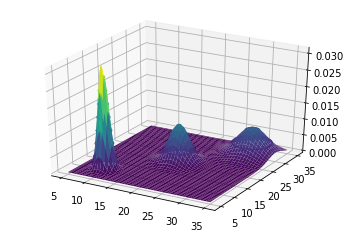

In [167]:
x = np.linspace(5, 35, 100)
y = np.linspace(5, 35, 100)
x, y = np.meshgrid(x, y)

data = np.stack((x.flatten(), y.flatten()), axis=1)
prob = mvgmm.prob(data).numpy()

ax = plt.axes(projection='3d')
plt.contour(x, y, prob.reshape((100, 100)));
ax.plot_surface(x, y, prob.reshape((100,100)), cmap='viridis');